<a href="https://colab.research.google.com/github/mr-alamdari/Single-Object-Segmentation-Pytorch/blob/main/Single_Object_Segmentation_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import copy
import scipy
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
import torch
import torchvision
import torchsummary

#1.Data

###The Dataset is From Automated measurement of fetal head circumference competition on the Grand Challenge website

####The dataset contains the two-dimensional (2D) ultrasound images of the standard plane [Source](https://zenodo.org/record/1322001#.XcX1jk9KhhE)

In [2]:
!wget https://zenodo.org/record/1322001/files/training_set.zip
!wget https://zenodo.org/record/1322001/files/test_set.zip
print('The Dataset is Downloaded')

--2022-04-01 11:32:33--  https://zenodo.org/record/1322001/files/training_set.zip
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 132986834 (127M) [application/octet-stream]
Saving to: ‘training_set.zip’

training_set.zip    100%[===================>] 126.83M  8.49MB/s    in 14s     

2022-04-01 11:32:50 (9.06 MB/s) - ‘training_set.zip’ saved [132986834/132986834]

--2022-04-01 11:32:50--  https://zenodo.org/record/1322001/files/test_set.zip
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 43751086 (42M) [application/octet-stream]
Saving to: ‘test_set.zip’

test_set.zip        100%[===================>]  41.72M  10.3MB/s    in 4.4s    

2022-04-01 11:32:57 (9.42 MB/s) - ‘test_set.zip’ saved [43751086/43751086]

The Dataset is Downloa

In [ ]:
!unzip training_set.zip
!unzip test_set.zip
print('Unzip is Finished')

Archive:  training_set.zip
   creating: training_set/
 extracting: training_set/100_2HC.png  
  inflating: training_set/100_2HC_Annotation.png  
 extracting: training_set/101_HC.png  
  inflating: training_set/101_HC_Annotation.png  
 extracting: training_set/102_2HC.png  
  inflating: training_set/102_2HC_Annotation.png  
 extracting: training_set/103_HC.png  
  inflating: training_set/103_HC_Annotation.png  
 extracting: training_set/104_HC.png  
  inflating: training_set/104_HC_Annotation.png  
 extracting: training_set/105_HC.png  
  inflating: training_set/105_HC_Annotation.png  
 extracting: training_set/106_HC.png  
  inflating: training_set/106_HC_Annotation.png  
 extracting: training_set/107_HC.png  
  inflating: training_set/107_HC_Annotation.png  
 extracting: training_set/108_2HC.png  
  inflating: training_set/108_2HC_Annotation.png  
 extracting: training_set/109_HC.png  
  inflating: training_set/109_HC_Annotation.png  
 extracting: training_set/10_2HC.png  
  inflating

In [ ]:
os.mkdir('/content/data')
os.replace('/content/training_set', '/content/data/training_set')
os.replace('/content/test_set', '/content/data/test_set')
os.remove('/content/training_set.zip')
os.remove('/content/test_set.zip')

In [ ]:
path2train = '/content/data/training_set'
path2test = '/content/data/test_set'

imgs_list, annts_list = list(), list()
for path in os.listdir(path2train):
  if 'Thumbs.db' in path:
    continue
  if 'Annotation' in path:
    annts_list.append(path)
  else:
    imgs_list.append(path)

In [ ]:
len(annts_list), len(imgs_list)

In [ ]:
def show_img_mask(img, mask):
  if torch.is_tensor(img):
    img = torchvision.transforms.functional.to_pil_image(img)
    mask = torchvision.transforms.functional.to_pil_image(mask)
  img_mask = mark_boundaries(np.array(img),
                              np.array(mask),
                            outline_color=(0, 1, 0),
                              color=(0, 1, 0))
  plt.imshow(img_mask)

In [ ]:
def show_img(img_list, n):
  for im in np.random.choice(img_list, n):
    path2img = f'{path2train}/{im}'
    path2ann = path2img.replace('.png', '_Annotation.png')
    img = Image.open(path2img)
    annt_edges = Image.open(path2ann)
    mask = scipy.ndimage.binary_fill_holes(annt_edges)

    plt.figure(figsize=(20, 100))
    plt.subplot(1, n, 1)
    plt.imshow(img, cmap='gray')
    
    plt.subplot(1, n, 2)
    plt.imshow(mask, cmap='gray')

    plt.subplot(1, n, 3)
    show_img_mask(img, mask)

In [ ]:
show_img(imgs_list, 10)

In [ ]:
def plot_history(history, loss=True):

  num_epochs = len(history['train'])
  print(num_epochs)
  title = 'Loss' if loss else 'Accuracy'
  plt.title(f'Train Validation {title}')
  plt.plot(range(1, num_epochs+1), history['train'], label='Train')
  plt.plot(range(1, num_epochs+1), history['val'], label='Validation')
  plt.xlabel('Trainig Epochs')
  plt.ylabel(title)
  plt.legend()
  plt.grid()
  plt.show()

##Data Augmentation

####I will use the albumentations package to augment the data for segmentation tasks:
#####!pip install imgaug
#####!pip install albumentations

In [ ]:
# !pip install imgaug
# !pip install albumentations

In [ ]:
from albumentations import HorizontalFlip, VerticalFlip, Compose, Resize

h, w = 128, 192
transform_train = Compose([Resize(h, w),
                           HorizontalFlip(p=0.5),
                           VerticalFlip(p=0.5)])

transform_val = Resize(h, w)

In [ ]:
class Fetal_Dataset(torch.utils.data.Dataset):

  def __init__(self, path2data, transform=None):

    imgs_list, annts_list = list(), list()
    for path in os.listdir(path2data):
      if 'Thumbs.db' in path:
        continue
      elif 'Annotation' in path:
        annts_list.append(path)
      else:
        imgs_list.append(path)

    self.path2imgs = [os.path.join(path2data, pi) for pi in imgs_list]
    self.path2annts = [os.path.join(path2data, pa) for pa in annts_list]
    self.transform = transform
  
  def __len__(self):
    return len(self.path2imgs)
  
  def __getitem__(self, idx):
    path2img = self.path2imgs[idx]
    image = Image.open(path2img)   
    path2annt = self.path2annts[idx]
    annt_edges = Image.open(path2annt)
    mask = scipy.ndimage.binary_fill_holes(annt_edges)
    mask = mask.astype('uint8')
    image= np.array(image)

    if self.transform:
      augmented_img = self.transform(image=image, mask=mask)
      image = augmented_img['image']
      mask = augmented_img['mask']

    image = torchvision.transforms.functional.to_tensor(image)
    mask = 255 * torchvision.transforms.functional.to_tensor(mask)
    return image, mask

In [ ]:
fetal_ds1 = Fetal_Dataset(path2train, transform=transform_train)
fetal_ds2 = Fetal_Dataset(path2train, transform=transform_val)

In [ ]:
img, mask = fetal_ds1[np.random.randint(len(fetal_ds1))]
show_img_mask(img, mask)

In [ ]:
from sklearn import model_selection
sss = model_selection.ShuffleSplit(n_splits=1, test_size=0.2, random_state=32)
indices = range(len(fetal_ds1))

In [ ]:
for train_index, val_index in sss.split(indices):
  print(len(train_index), len(val_index))

In [ ]:
train_ds = torch.utils.data.Subset(fetal_ds1, train_index)
test_ds = torch.utils.data.Subset(fetal_ds2, val_index)

In [ ]:
train_dl = torch.utils.data.DataLoader(train_ds,
                                       batch_size=8,
                                       shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds,
                                      batch_size=16,
                                      shuffle=False)

In [ ]:
for img_b, mask_b in train_dl:
  print(img_b.shape, img_b.dtype)
  print(mask_b.shape, mask_b.dtype)
  break

#2.Model
####Encoder-Decoder with CNN

In [ ]:
import torch.nn as nn
import torch.nn.functional as f

class SegNet(torch.nn.Module):
  def __init__(self, params):
    super(SegNet, self).__init__()

    c_in, h_in, w_in = params['input_shape']
    init_f = params['initial_filters']
    num_outputs = params['num_outputs']

    self.conv1 = torch.nn.Conv2d(c_in,init_f, kernel_size=3, stride=1, padding=1)
    self.conv2 = torch.nn.Conv2d(init_f, 2*init_f, kernel_size=3, stride=1, padding=1)
    self.conv3 = torch.nn.Conv2d(2*init_f, 4*init_f, kernel_size=3, padding=1)
    self.conv4 = torch.nn.Conv2d(4*init_f, 8*init_f, kernel_size=3, padding=1)
    self.conv5 = torch.nn.Conv2d(8*init_f, 16*init_f, kernel_size=3, padding=1)

    self.upsample = torch.nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    self.conv_up1 = torch.nn.Conv2d(16*init_f, 8*init_f, kernel_size=3, padding=1)
    self.conv_up2 = torch.nn.Conv2d(8*init_f, 4*init_f, kernel_size=3, padding=1)
    self.conv_up3 = torch.nn.Conv2d(4*init_f, 2*init_f, kernel_size=3, padding=1)
    self.conv_up4 = torch.nn.Conv2d(2*init_f, init_f, kernel_size=3, padding=1)

    self.conv_out = torch.nn.Conv2d(init_f, num_outputs, kernel_size=3, padding=1)

  def forward(self, x):
    x = f.relu(self.conv1(x))
    x = f.max_pool2d(x, 2, 2)

    x = f.relu(self.conv2(x))
    x = f.max_pool2d(x, 2, 2)

    x = f.relu(self.conv3(x))
    x = f.max_pool2d(x, 2, 2)

    x = f.relu(self.conv4(x))
    x = f.max_pool2d(x, 2, 2)
    
    x = f.relu(self.conv5(x))    

    x = self.upsample(x)
    x = f.relu(self.conv_up1(x))
    
    x = self.upsample(x)
    x = f.relu(self.conv_up2(x))

    x = self.upsample(x)
    x = f.relu(self.conv_up3(x))

    x = self.upsample(x)
    x = f.relu(self.conv_up4(x))

    x = self.conv_out(x)

    return x

In [ ]:
params_model={
        "input_shape": (1,h,w),
        "initial_filters": 16, 
        "num_outputs": 1,
            }

model = SegNet(params_model)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [ ]:
print(model)

In [ ]:
torchsummary.summary(model, input_size=(1, h, w))

#3.Train The Model

In [ ]:
def loss_batch(output, target, opt=None, smooth=1e-5):

  #BCE Loss
  bce = torch.nn.functional.binary_cross_entropy_with_logits(output, target, reduction='sum')

  #Dice Loss
  output = torch.sigmoid(output)
  intersection = (output*target).sum(dim=(2, 3))
  union = output.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
  dice = 2.0 * (intersection + smooth) / (union + smooth)
  dice_loss = 1.0 - dice
  dice_loss =  dice_loss.sum()
  metric = dice.sum()
  
  #Total Loss = BCE + Dice
  loss = bce + dice_loss

  if opt is not None:
    opt.zero_grad()
    loss.backward()
    opt.step()

  return loss.item(), metric

In [ ]:
opt = torch.optim.Adam(model.parameters(), lr=3e-4)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=20, verbose=1)

In [ ]:
def get_lr(opt):
  for group in opt.param_groups:
    return group['lr']

In [ ]:
def loss_epoch(model, dataset_dl, sanity_check=False, opt=None):
  running_loss = 0.0
  running_metrics = 0.0
  len_data = len(dataset_dl.dataset)

  for x, y in dataset_dl:
    x = x.to(device)
    y = y.to(device)
    output = model(x)
    loss, metric = loss_batch(output, y, opt)
    running_loss += loss
    
    if metric is not None:
      running_metrics += metric
    
    if sanity_check:
      break
    
  
  loss = running_loss / float(len_data)
  metrics = running_metrics / float(len_data)
  return loss, metric

In [ ]:
def train_val(model, params):
  num_epochs = params['num_epochs']
  opt = params['optimizer']
  train_dl = params['train_dl']
  val_dl = params['val_dl']
  sanity_check = params['sanity_check']
  lr_scheduler = params['lr_scheduler']
  path2weights = params['path2weights']

  loss_history = {'train':[], 'val': []}
  metrics_history = {'train':[], 'val': []}

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = float('inf')

  for epoch in range(num_epochs):
    current_lr = get_lr(opt)

    model.train()
    train_loss, train_metric = loss_epoch(model, train_dl, sanity_check, opt)
    loss_history['train'].append(train_loss)
    metrics_history['train'].append(train_metric.detach().numpy())

    model.eval()
    with torch.no_grad():
      val_loss, val_metric = loss_epoch(model, val_dl, sanity_check)
      loss_history['val'].append(val_loss)
      metrics_history['val'].append(val_metric.detach().numpy())

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())
      torch.save(model.state_dict(), path2weights)
    
    lr_scheduler.step(val_loss)
    if current_lr != get_lr(opt):
      model.load_state_dict(best_model_wts)
      print('Load Best Models')
    
    print(f"Epoch: {epoch+1}/{num_epochs}, current lr={current_lr}, Train Loss: {train_loss:.4f}, Train Accuracy: %{train_metric*100:.3f}, Val Loss: {val_loss:.4f}, Val Accuracy: %{val_metric*100:.3f}")

  model.load_state_dict(best_model_wts)
  return model, loss_history, metrics_history

In [ ]:
path2models = '/content/models/'
if not os.path.exists(path2models):
  os.mkdir(path2models)

In [ ]:
params_train = {
    'num_epochs': 100,
    'optimizer': opt,
    'train_dl': train_dl,
    'val_dl': test_dl,
    'sanity_check': False,
    'lr_scheduler': lr_scheduler,
    'path2weights': path2models + 'weights.pt'
}

In [ ]:
model, loss_hist, metric_hist = train_val(model, params_train)

In [ ]:
plot_history(loss_hist, loss=True)

In [ ]:
plot_history(metric_hist, loss=False)

#4.Deploy

In [208]:
path2test = '/content/data/test_set/'
testList = [p for p in os.listdir(path2test)]
print(len(testList))

336


In [265]:
model = SegNet(params_model)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

path2weights = '/content/models/weights.pt'
model.load_state_dict(torch.load(path2weights))
model = model.to(device)

model.eval()

SegNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upsample): Upsample(scale_factor=2.0, mode=bilinear)
  (conv_up1): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_up2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_up3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_up4): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_out): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [297]:
def show_deployed_img(img_list, n):
  w, h = 192, 128
  for im in np.random.choice(img_list, n):
    path2img = f'{path2test}/{im}'
    img = Image.open(path2img)
    img = img.resize((w, h))
    tensor_img = torchvision.transforms.functional.to_tensor(img).unsqueeze(0).to(device)
    pred = model(tensor_img)
    pred = torch.sigmoid(pred)[0]
    mask_pred = pred[0] >= 0.5  #To Get Binary Mask

    plt.figure(figsize=(20, 10))
    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap='gray')
    
    plt.subplot(1, 3, 2)
    plt.imshow(mask_pred, cmap='gray')

    plt.subplot(1, 3, 3)
    show_img_mask(img, mask_pred)

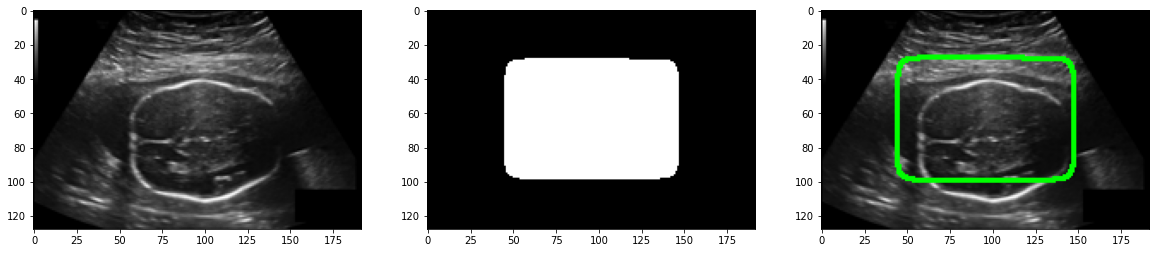

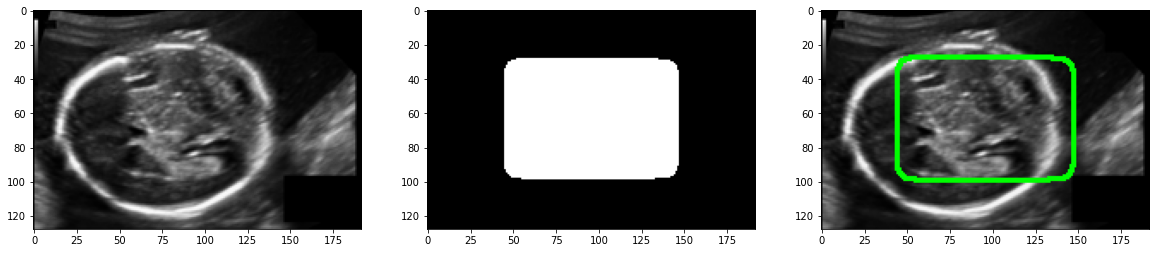

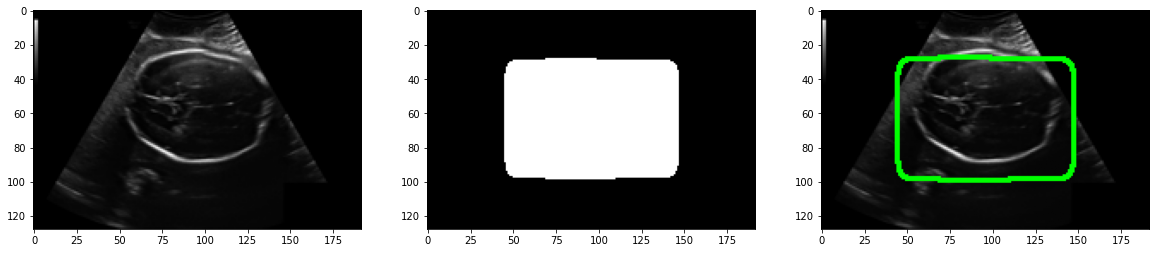

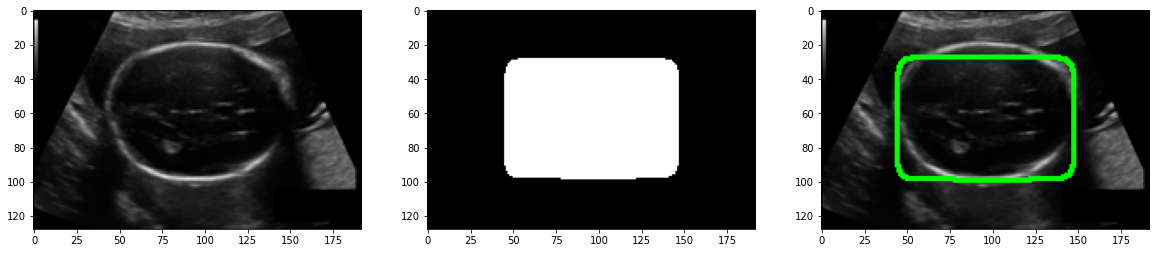

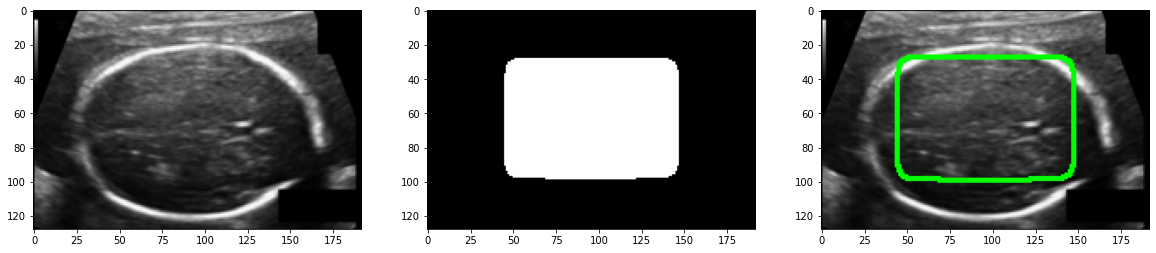

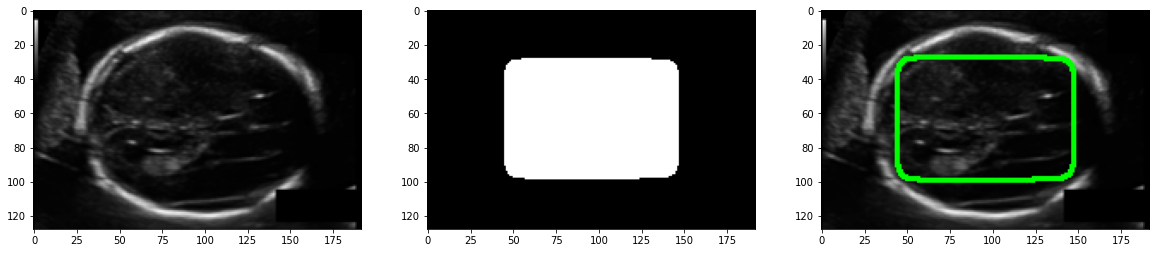

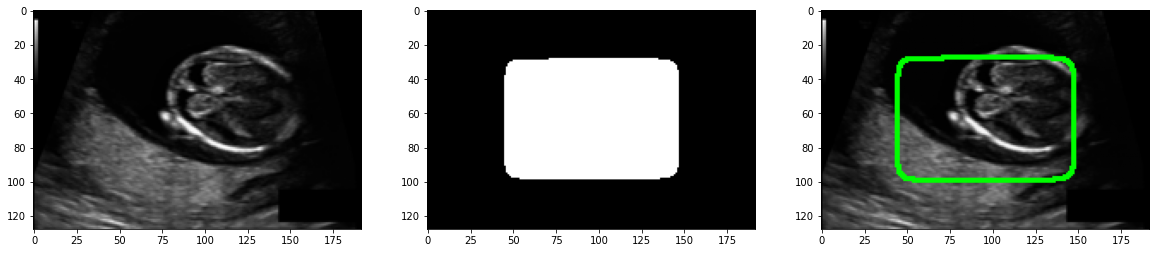

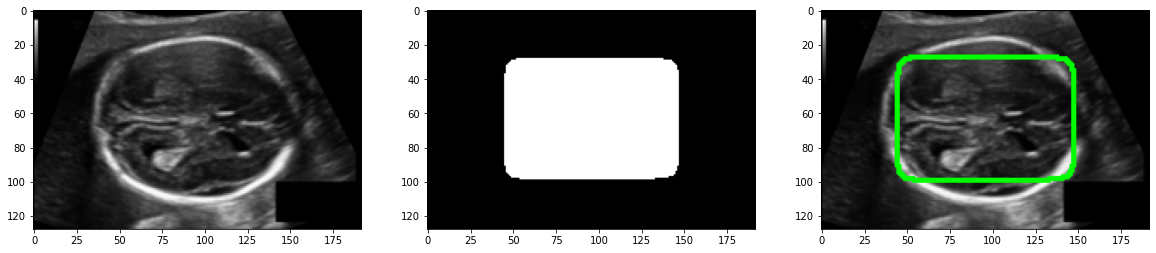

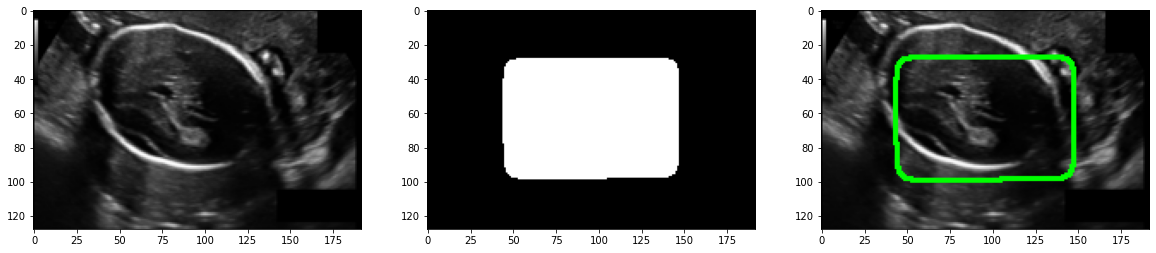

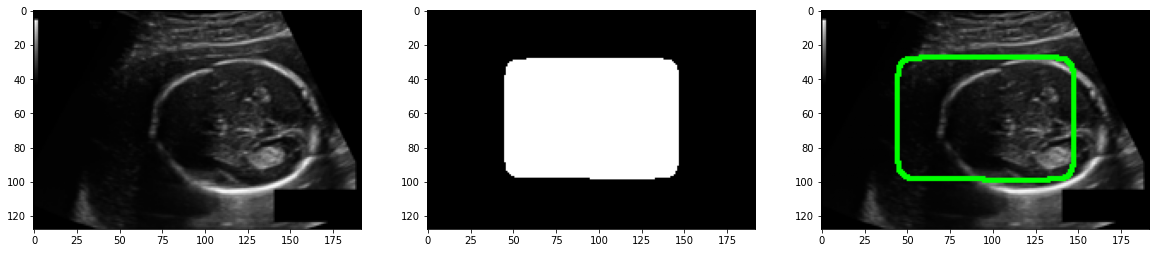

In [299]:
show_deployed_img(testList, 10)